In [95]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
# read the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [97]:
len(words)

32033

In [98]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
s_to_i = {'.' : 0} | {s: i + 1 for i, s in enumerate(chars)}
i_to_s = {i: s for s, i in s_to_i.items()}
print(i_to_s)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [99]:
# build the dataset

block_size = 3

def build_dataset(words):
	X, Y = [], []
	for w in words:
		# print(w)
		context = [0] * block_size
		for ch in w + '.':
			idx = s_to_i[ch]
			X.append(context)
			Y.append(idx)
			# print(''.join(i_to_s[i] for i in context), '-->', i_to_s[idx])
			context = context[1:] + [idx]
	
	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [100]:
X_train.shape, Y_train.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [101]:
emb_length = 10
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_length), generator=g)
W1 = torch.randn((emb_length * block_size, 200), generator=g)
b1 = torch.randn((200,), generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27,), generator=g)
parameters = [C, W1, b1, W2, b2]

In [102]:
sum(p.nelement() for p in parameters) # num of params in total

11897

In [103]:
for p in parameters:
	p.requires_grad = True

In [104]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [105]:
lri = []
lossi = []
stepi = []
iter_count = 0
iter_by = 200000

In [106]:
for i in range(iter_by):
	
	# minibatch
	minibatch = torch.randint(0, X_train.shape[0], (32,))

	# forward pass
	emb = C[X_train[minibatch]] # (32, 3, 2)
	h = torch.tanh(emb.view(-1, emb_length * block_size) @ W1 + b1) # (32, 100)
	logits = h @ W2 + b2 # (32, 27)
	loss = F.cross_entropy(logits, Y_train[minibatch])
	# print(loss.item())

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	# lr = lrs[i]
	lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	# lri.append(lre[i])
	stepi.append(i + iter_count * iter_by)
	lossi.append(loss.log10().item())

iter_count += 1
# print(loss.item())

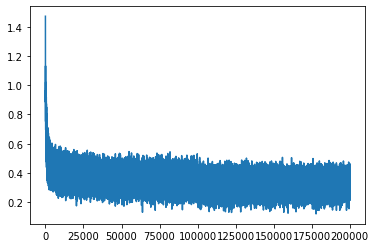

In [107]:
plt.plot(stepi, lossi)

In [108]:
emb = C[X_train] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_length * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_train)
print(loss.item())

2.1240742206573486


In [109]:
emb = C[X_val] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb_length * block_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y_val)
print(loss.item())

2.1619186401367188


In [110]:
# plt.figure(figsize=(10, 10))
# plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
# for i in range(C.shape[0]):
# 	plt.text(C[i, 0].item(), C[i, 1].item(), i_to_s[i], ha='center', va='center', color='white')
# plt.grid('minor')